In [2]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *
from constants import *

In [3]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [4]:
%run sequencing_sp2.ipynb

# Open DB

In [157]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'min_score', 'match_tab_index'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [6]:
hdc = Hdc(10_000, xp)

In [7]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs


((100, 9), (20, 9))


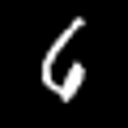
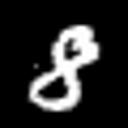
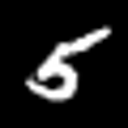
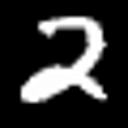
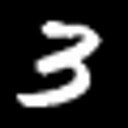
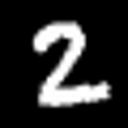
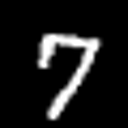
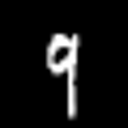
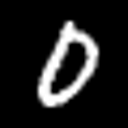
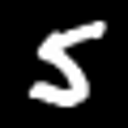
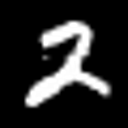
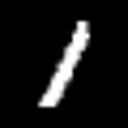
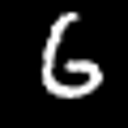
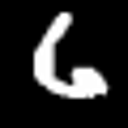
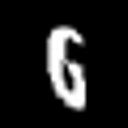
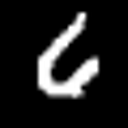

In [8]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

In [9]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

In [131]:
Engram = namedtuple('Engram', ['image_id', 'value', 'si_ind_dict', 'seq', 'phased_seq', 'phased_x_seq', 'phased_y_seq', 'phased_normal_seq', 'max_std_sq'])
Matchee = namedtuple('Matchee', ['si_ind_dict', 'seq', 'xy_seq', 'x_seq', 'y_seq', 'x_sq_seq', 'y_sq_seq', 'normal_seq'])

In [132]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

def create_engram(df_image):
    image_id = int(df_image.name)
    value = str(df_image['value'])
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    
    sequence = get_sequence(sequences)
    normal_sequence = get_normal_sequence(sequence, si_ind_dict)
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    
    assert sequence.shape[0] == xy_sequence.shape[0]
    assert xy_sequence.shape[0] == vec_sequence.shape[0]
    assert vec_sequence.shape[0] == normal_sequence.shape[0]

    phased_sequences = []
    phased_xy_sequences = []
    phased_normal_sequences = []
    
    for phase in range(vec_sequence.shape[0]):
        phased_vec_sequence = np.roll(vec_sequence, -phase, axis=0)
        xy_list = [(0, 0)]
            
        for vec in phased_vec_sequence[:-1]:
            xy_list.append((xy_list[-1][0] + vec[0], xy_list[-1][1] + vec[1]))
    
        phased_sequences.append(np.roll(sequence, -phase, axis=0))
        phased_xy_sequences.append(np.array(xy_list))
        phased_normal_sequences.append(np.roll(normal_sequence, -phase, axis=0))
    
    phased_normal_sequences = np.array(phased_normal_sequences)
    phased_xy_sequences = np.array(phased_xy_sequences)
    phased_x_sequences = phased_xy_sequences[..., 0]
    phased_y_sequences = phased_xy_sequences[..., 1]
    max_std = max(np.std(phased_x_sequences[0]), np.std(phased_y_sequences[0]))
    return Engram(image_id=image_id,
                  value=value,
                  si_ind_dict=si_ind_dict,
                  seq=sequence,
                  phased_seq=phased_sequences, 
                  phased_x_seq=phased_x_sequences, 
                  phased_y_seq=phased_y_sequences, 
                  phased_normal_seq=phased_normal_sequences, 
                  max_std_sq=max_std ** 2)

def create_matchee(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    
    sequence = get_sequence(sequences)
    normal_sequence = get_normal_sequence(sequence, si_ind_dict)
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    
    x_seq = xy_sequence[:,0]
    y_seq = xy_sequence[:,1]
    x_sq_seq = x_seq * x_seq
    y_sq_seq = y_seq * y_seq
    
    assert sequence.shape[0] == normal_sequence.shape[0]
    assert normal_sequence.shape[0] == x_seq.shape[0]
    assert x_seq.shape[0] == y_seq.shape[0]
    assert y_seq.shape[0] == x_sq_seq.shape[0]
    assert x_sq_seq.shape[0] == y_sq_seq.shape[0]

    return Matchee(si_ind_dict=si_ind_dict, 
                   seq=sequence, 
                   xy_seq=xy_sequence, 
                   x_seq=x_seq, 
                   y_seq=y_seq, 
                   x_sq_seq=x_sq_seq, 
                   y_sq_seq=y_sq_seq, 
                   normal_seq=normal_sequence)

def _compute_dist_sq_matrix(engram, matchee, matchee_pivot_point_i):
    # Batch compute matrix: (x1 - x2)^2 = x1^2 - 2*x1*x2 + x2^2
    x1 = engram.phased_x_seq.copy()
    x1 = x1.reshape(-1, 1)
    x2 = matchee.x_seq[:,np.newaxis]

    # Move all phased x-es to pivot point
    x1 += x2[matchee_pivot_point_i, 0]
    
    x1_sq = (x1 * x1).T
    x1_sq = np.vstack([x1_sq, np.ones(x1_sq.shape[-1])])
    x2_sq = np.vstack([np.ones(matchee.x_sq_seq.shape[-1]), matchee.x_sq_seq])
    x1_sq_plus_x2_sq = x1_sq.T @ x2_sq
    x1_times_x2 = x1 @ x2.T
    x_dist_sq = x1_sq_plus_x2_sq - (2 * x1_times_x2)
    x_dist_sq = x_dist_sq.reshape(engram.phased_x_seq.shape[0], engram.phased_x_seq.shape[0], matchee.x_seq.shape[0])

    # Batch compute matrix: (y1 - y2)^2 = y1^2 - 2*y1*y2 + y2^2
    y1 = engram.phased_y_seq.copy()
    y1 = y1.reshape(-1, 1)
    y2 = matchee.y_seq[:,np.newaxis]

    # Move all phased y-es to pivot point
    y1 += y2[matchee_pivot_point_i, 0]
    
    y1_sq = (y1 * y1).T
    y1_sq = np.vstack([y1_sq, np.ones(y1_sq.shape[-1])])
    y2_sq = np.vstack([np.ones(matchee.y_sq_seq.shape[-1]), matchee.y_sq_seq])
    y1_sq_plus_y2_sq = y1_sq.T @ y2_sq
    y1_times_y2 = y1 @ y2.T
    y_dist_sq = y1_sq_plus_y2_sq - (2 * y1_times_y2)
    y_dist_sq = y_dist_sq.reshape(engram.phased_y_seq.shape[0], engram.phased_y_seq.shape[0], matchee.y_seq.shape[0])

    # Batch compute matrix: dot_prod(normal1, normal2), then threshold, then square
    n1 = engram.phased_normal_seq.reshape(-1, 2)
    n2 = matchee.normal_seq.T
    n1_dot_prod_n2 = np.abs(n1 @ n2)
    n_dist_sq = np.where(n1_dot_prod_n2 < COS_SIM_45, engram.max_std_sq, 0)
    n_dist_sq = n_dist_sq.reshape(engram.phased_normal_seq.shape[0], engram.phased_normal_seq.shape[0], matchee.normal_seq.shape[0])

    # Resulting distance square matrix combines all of squared dists
    dist_sq = x_dist_sq + y_dist_sq + n_dist_sq
    return dist_sq

def interpret(engram, matchee, pivot_point_i):
    dist_sq = _compute_dist_sq_matrix(engram, matchee, pivot_point_i)
    interp_tabs = {} # key - phase_index, value - array (engram_si_serial, matchee_si_serial, dist) = interp tab
    
    for phase_index in range(dist_sq.shape[0]):
        dist_sq_for_phase = dist_sq[phase_index].copy()
        dist_sq_stride = dist_sq_for_phase.shape[1]
        sort_indices = np.argsort(dist_sq_for_phase, axis=None)
    
        interp_tab = []
        i_to_j_dict = {}
        j_to_i_dict = {}
        
        for flat_ij in sort_indices.ravel():
            i = flat_ij // dist_sq_stride
            j = flat_ij % dist_sq_stride
            d = dist_sq_for_phase[i,j]
    
            if d >= 0:
                if d < engram.max_std_sq:
                    interp_tab.append((i, j, d))
                    i_to_j_dict[i] = j
                    j_to_i_dict[j] = i
                    
                dist_sq_for_phase[i,:] = -1
                dist_sq_for_phase[:,j] = -1
    
        interp_tab = np.array(interp_tab, dtype='i8')
        interp_tab_mask = []
    
        phased_sequence = engram.phased_seq[phase_index]
        # Filter out from interp_tab connections which do not belong to adjacent sis on both sides.
        # This way we can filter out unwanted crosses of connections. In other words we favor seq to seq matches
        for interp_tab_row in interp_tab:
            i = interp_tab_row[0]
            j = interp_tab_row[1]
    
            is_standalone = (not (i-1) in i_to_j_dict and not (i+1) in i_to_j_dict and not (j-1) in j_to_i_dict and not (j+1) in j_to_i_dict)
            is_prev_i_ok = i_to_j_dict.get(i-1, -999) in (j-1, j+1)
            is_next_i_ok = i_to_j_dict.get(i+1, -999) in (j-1, j+1)
            is_prev_j_ok = j_to_i_dict.get(j-1, -999) in (i-1, i+1)
            is_next_j_ok = j_to_i_dict.get(j+1, -999) in (i-1, i+1)
    
            interp_tab_mask.append(is_standalone or ((is_prev_i_ok or is_next_i_ok) and (is_prev_j_ok or is_next_j_ok)))
        
        interp_tabs[phase_index] = interp_tab[interp_tab_mask]
    
    interp_score_vecs = np.zeros((len(interp_tabs), 2))
    
    for phase_index, interp_tab in interp_tabs.items():
        unmatched_engram_sis = set(range(dist_sq.shape[0]))
        unmatched_matchee_sis = set(range(dist_sq.shape[2]))

        if interp_tab.size > 0:
            unmatched_engram_sis -= set(interp_tab[:,0])
            unmatched_matchee_sis -= set(interp_tab[:,1])
            
        interp_score_vecs[phase_index] = (len(unmatched_engram_sis), len(unmatched_matchee_sis))
    
    interp_integr_scores = np.sqrt(np.sum(interp_score_vecs ** 2, axis=1))
    return np.argmin(interp_integr_scores), interp_integr_scores, interp_score_vecs, interp_tabs

def render_interp_result(engram, matchee, pivot_point_i, interp_result):
    best_score_index, scores, score_vecs, interp_tabs = interp_result
    best_score = scores[best_score_index]
    
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    s = engram.phased_seq[best_score_index]
    s = np.vstack([s, np.roll(s, -1, axis=0)]).T
    
    xy_list = np.vstack([engram.phased_x_seq[best_score_index], engram.phased_y_seq[best_score_index]]).T
    xy_list = xy_list.astype('f')
    
    assert s.shape[0] == xy_list.shape[0]
    
    matchee_pt_xy = matchee.xy_seq[pivot_point_i]
    xy_list += matchee_pt_xy
    xy_list = np.hstack([xy_list, np.roll(xy_list, -1, axis=0)])
    
    engram_si_serial_to_xy = {}
    
    for si_serial, (xy_list_row, s_row) in enumerate(zip(xy_list[:-1], s[:-1])):
        pt_from = xy_list_row[0], xy_list_row[1]
        pt_to = xy_list_row[2], xy_list_row[3]
        
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
    
        si_from = engram.si_ind_dict[s_row[0]]
        si_to = engram.si_ind_dict[s_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
        draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    matchee_si_serial_to_xy = {}
    
    for si_serial, (xy_list_row, s_row) in enumerate(zip(zip(matchee.xy_seq, matchee.xy_seq[1:]), zip(matchee.seq, matchee.seq[1:]))):
        pt_from = xy_list_row[0][0], xy_list_row[0][1] 
        pt_to = xy_list_row[1][0], xy_list_row[1][1]
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        # color = 'red' if np.linalg.norm(vec) < 10 else 'gray'
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
    
        si_from = matchee.si_ind_dict[s_row[0]]
        si_to = matchee.si_ind_dict[s_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        # draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    interp_tab = interp_tabs[best_score_index]
    
    for engram_si_serial, image_si_serial, dist in interp_tab:
        engram_si_ind_xy = engram_si_serial_to_xy[engram_si_serial]
        matchee_si_xy = matchee_si_serial_to_xy[image_si_serial]
        draw.line([engram_si_ind_xy[0], engram_si_ind_xy[1], matchee_si_xy[0], matchee_si_xy[1]], width=1, fill='white')
    
    draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)

    score_vec = score_vecs[best_score_index]
    deficit = (score_vec[0] + score_vec[1])/(len(engram.seq) + len(matchee.seq))
    
    draw.text((image_pil.size[0] / 2, 10), f'score={scores[best_score_index]:.0f}, {score_vecs[best_score_index].astype(int)}, def={deficit * 100:.0f}%', font_size=24, anchor='mt')
    return image_pil


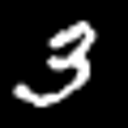
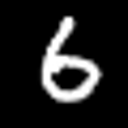
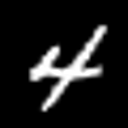
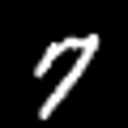
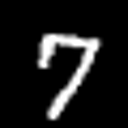
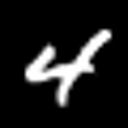
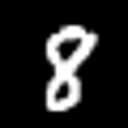
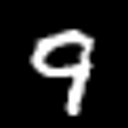

In [133]:
# %%time
image_ids = RNG.choice(df_train_images.index, 8, replace=False)
images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
captions = [f'{image_ids[0]}']

engram_image_id = image_ids[0]
matchee_image_ids = image_ids[1:]
engram = create_engram(df_train_images.loc[engram_image_id])
matchees = list(map(lambda image_id: create_matchee(df_train_images.loc[image_id]), matchee_image_ids))
interp_results = []

for i, (matchee, image_id) in enumerate(zip(matchees, matchee_image_ids)):
    interp_result = interpret(engram, matchee, 0)
    interp_results.append(interp_result)
    best_score_index, scores, score_vecs, _ = interp_result
    score_vec = score_vecs[best_score_index]
    deficit = (score_vec[0] + score_vec[1])/(len(engram.seq) + len(matchee.seq))
    captions.append(f'{i}) {image_id}, score={scores[best_score_index]:.0f}, def={deficit * 100:.0f}%')

display_images_grid(images, captions=captions, col_count=len(image_ids))

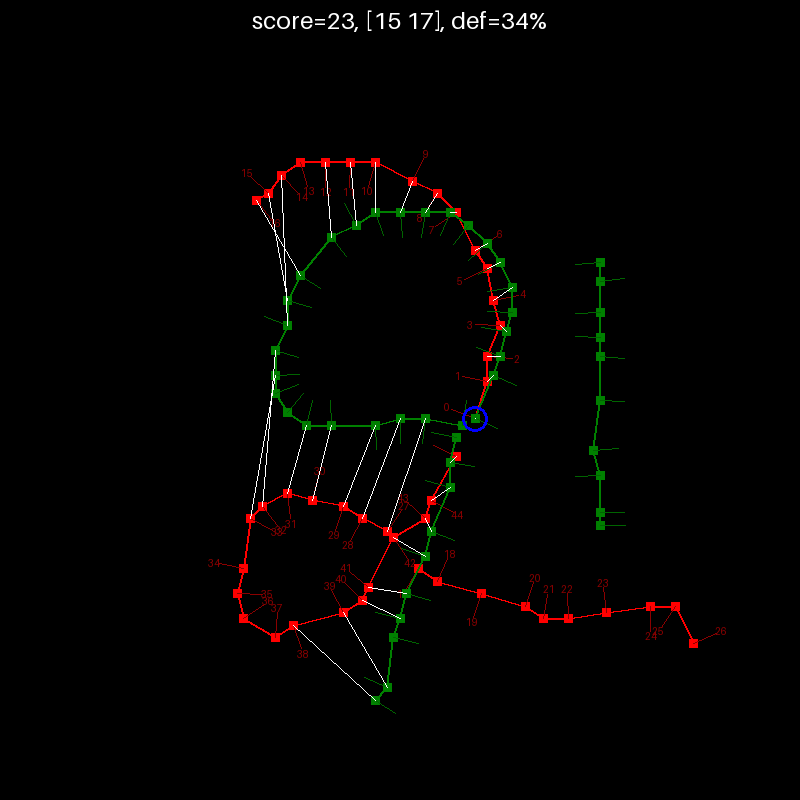

In [123]:
matchee_i = 1
render_interp_result(engram, matchees[matchee_i], 0, interp_results[matchee_i])

# Train

In [146]:
ENGRAMS = []

In [147]:
def get_match_tab(matchee):
    match_tab_columns = defaultdict(list)
    
    for engram_i, engram in enumerate(ENGRAMS):
        interp_result = interpret(engram, matchee, 0)
        # np.argmin(interp_integr_scores), interp_integr_scores, interp_score_vecs, interp_tabs
        best_score_index, scores, score_vecs, _ = interp_result
        best_score = scores[best_score_index]
        match_tab_columns['engram_i'].append(engram_i)
        match_tab_columns['image_id'].append(engram.image_id)
        match_tab_columns['value'].append(engram.value)
        match_tab_columns['best_score_index'].append(best_score_index)
        match_tab_columns['best_score'].append(best_score)
        match_tab_columns['scores'].append(scores)
        match_tab_columns['score_vecs'].append(score_vecs)

    return pd.DataFrame(match_tab_columns)

In [161]:
# %%time
train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [21514]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]

    for image_id in tqdm(image_ids, leave=False):
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        matchee = create_matchee(df_image)
        df_match_tab = get_match_tab(matchee)
        
        if len(df_match_tab) > 0:
            df_match_tab.sort_values(by=['best_score'], inplace=True)
            
            if df_match_tab.iloc[0]['value'] == image_value:
                continue

        engram = create_engram(df_image)
        ENGRAMS.append(engram)
        print(f'New engram for {image_id:5} {image_value}')

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

New engram for 49409 2
New engram for  3512 8
New engram for 20448 2
New engram for 26859 0
New engram for 39777 6
New engram for 46074 6
New engram for   426 7
New engram for 47057 8
Total engrams 49


# Test

In [175]:
%%time
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = [100006748]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee(df_image)
    df_match_tab = get_match_tab(matchee)
    match_tabs.append(df_match_tab)
    infer_value = ''
        
    if len(df_match_tab) > 0:
        df_match_tab.sort_values(by=['best_score'], inplace=True)
        infer_value = df_match_tab.iloc[0]['value']
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(0) # TODO: fix
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(df_match_tab.iloc[0]['image_id'])
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['min_score'].append(df_match_tab.iloc[0]['best_score'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    
assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 15.6 s, sys: 386 ms, total: 16 s
Wall time: 15.9 s


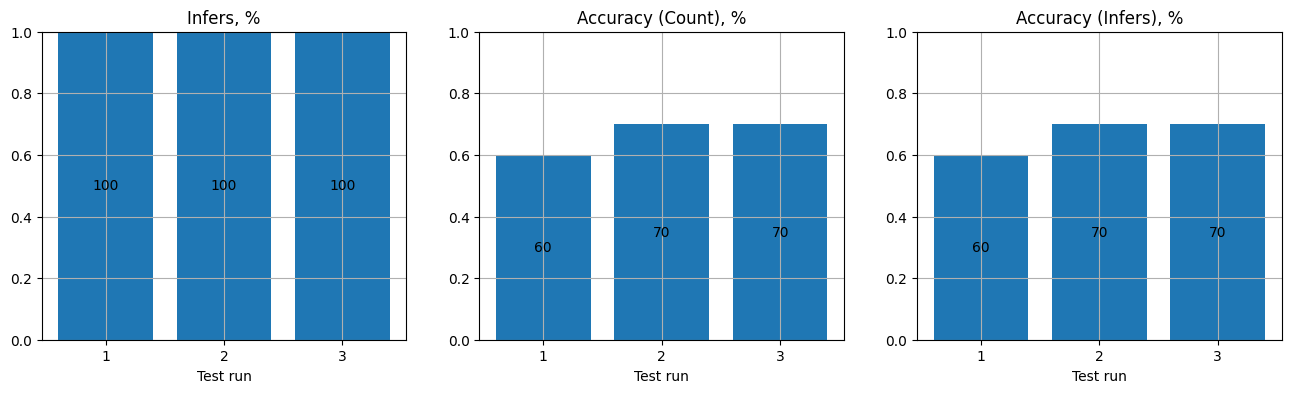

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,0,20,20,12,1.0,0.6,0.6
2,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,1,20,20,14,1.0,0.7,0.7
3,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,1,20,20,14,1.0,0.7,0.7


In [176]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [177]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'min_score', 'match_tab_index']]

,test_image_id,true_value,engram_image_id,infer_value,min_score,match_tab_index
40,100003117,5,9294,3,16.278821,0
42,100002995,6,33748,5,11.401754,2
44,100004526,3,33748,5,13.892444,4
49,100000942,6,33748,5,9.433981,9
51,100005039,4,37376,9,12.041595,11
57,100005854,7,37352,9,10.630146,17


In [178]:
df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value]

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,engram_image_id,infer_value,min_score,match_tab_index
41,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100004627,6,39577,6,9.219544,1
43,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100006640,7,426,7,9.055385,3
45,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100003413,0,16217,0,3.605551,5
46,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100002918,2,45453,2,10.000000,6
47,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100002350,2,57366,2,18.384776,7
48,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100003425,7,426,7,7.211103,8
50,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100007120,2,49409,2,7.810250,10
52,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100004125,6,39577,6,10.198039,12
53,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100007399,1,43017,1,5.000000,13
54,3,SQLITE3_SEQ_GRID_0_2_4096,[],0,1,test,100006251,4,7965,4,11.661904,14


In [123]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_correct = df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value]
# list(df_correct.match_tab_index)

In [179]:
match_tabs[7].head()

,engram_i,image_id,value,best_score_index,best_score,scores,score_vecs
5,5,57366,2,13,18.384776,"[26.419689627245813, 25.059928172283335, 25.05...","[[13.0, 23.0], [12.0, 22.0], [12.0, 22.0], [15..."
41,41,49409,2,26,18.788294,"[52.009614495783374, 53.41348144429457, 53.413...","[[32.0, 41.0], [33.0, 42.0], [33.0, 42.0], [31..."
20,20,54315,2,3,19.104973,"[26.1725046566048, 20.518284528683193, 26.1725...","[[18.0, 19.0], [14.0, 15.0], [18.0, 19.0], [13..."
43,43,20448,2,21,19.416488,"[45.79301256742124, 54.08326913195984, 44.4184...","[[24.0, 39.0], [30.0, 45.0], [23.0, 38.0], [24..."
35,35,33578,0,26,22.472205,"[49.040799340956916, 56.08029957123981, 50.447...","[[31.0, 38.0], [36.0, 43.0], [32.0, 39.0], [30..."


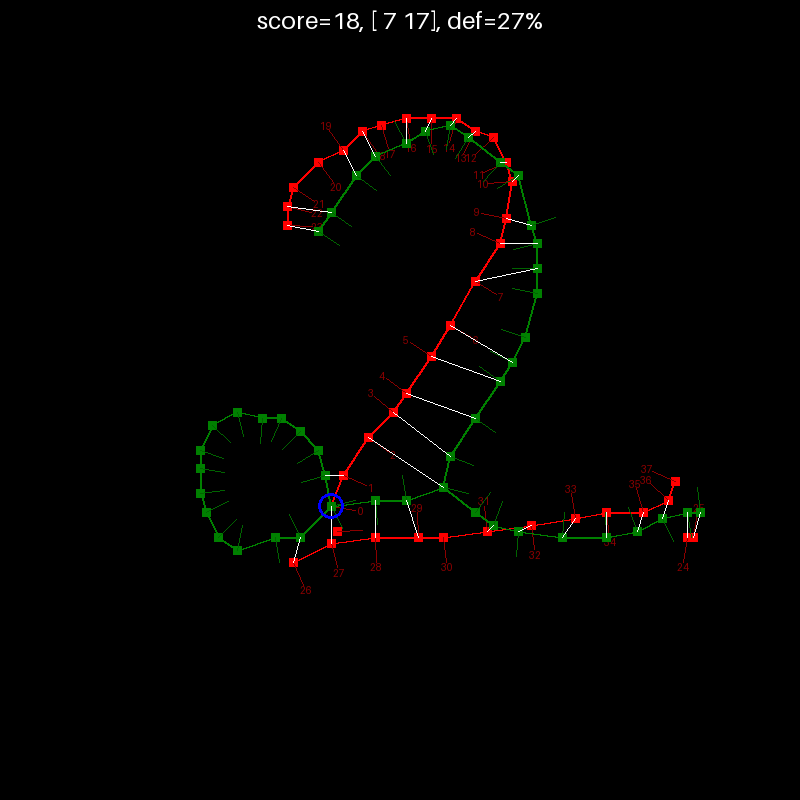

In [180]:
engram = ENGRAMS[5]
df_image = test_run_source[0].loc[100002350]
matchee = create_matchee(df_image)
r = interpret(engram, matchee, 0)
matchee_i = 1
render_interp_result(engram, matchee, 0, r)